### Setup

In [1]:
# Basic Util Packages
# from tqdm import tqdm
import logging
import time
import os

# Requests Packages
from concurrent.futures import ThreadPoolExecutor
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
import requests
import json

# Image Processing Packages
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv


c:\Users\adamc\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
SF_API_URL = 'https://api.scryfall.com'
SF_API_HEADERS = {
    'User_Agent' : 'card-classifier/0.1',
    'Accept' : '*/*'
}
SF_API_DELAY = 50 # ms - No ratelimit on *.scryfall.io

In [3]:
DATA_UPDATE = False
ART_PATH = 'data\\art'

In [4]:
# Create a session
session = requests.Session()

# Configure the HTTPAdapter with a connection pool size
adapter = HTTPAdapter(
    pool_connections=10,  # Number of connection pools
    pool_maxsize=50,      # Maximum number of connections in the pool
    max_retries=Retry(total=3, backoff_factor=0.3)  # Retry strategy
)

# Mount the adapter to the session
session.mount('http://', adapter)
session.mount('https://', adapter)

Logging setup

In [5]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

### Helper Functions

In [6]:
### Pull all download URIs
def get_uris():
    response = session.get(SF_API_URL+'/bulk-data', headers=SF_API_HEADERS)

    data = response.json()['data']
    # print(json.dumps(data, indent=4))

    # Extract all URI
    download_uri = {}
    for object in data:
        download_uri[object['type']] = object['download_uri']
    return download_uri

In [7]:
### Clean card names
def clean_cardname(name):
    return name.replace(' ', '_').replace('/', '_').replace(':', '_').replace('\'', '').replace('\"', '').replace('?', '').replace('!', '')

In [8]:
def download_image(entry, is_dfc=False, card_face=None):
    """
    Download a card image from a Scryfall JSON.

    Parameters:
    entry (dict): The card entry from Scryfall JSON.
    is_dfc (bool): Flag indicating if the card is a double-faced card.
    card_face (dict): The card face entry if the card is a double-faced card.

    Returns:
    None
    """
    if not is_dfc:
        filename = f"{clean_cardname(entry['name'])}_{entry['illustration_id']}.jpg"
        art_path = os.path.join(ART_PATH, filename)
        image_url = entry['image_uris']['art_crop']
    else:
        filename = f"{clean_cardname(card_face['name'])}_{card_face['illustration_id']}.jpg"
        art_path = os.path.join(ART_PATH, filename)
        image_url = card_face['image_uris']['art_crop']

    response = session.get(image_url, headers=SF_API_HEADERS)
    if response.status_code != 200:
        logging.error(f"Failed to download image for {entry['name']}: {response.status_code}")
        return
    with open(art_path, 'wb') as file:
        file.write(response.content)

In [9]:
def search_card_data(card_data, name=None, illustration_id=None, return_all=False):
    """
    Search for a downloaded card image by name or illustration ID.

    Parameters:
    - card_data (list): List of card data dictionaries.
    - name (str): Name of the card.
    - illustration_id (str): Illustration ID of the card.
    - return_all (bool): If True, return all matching cards in a List. If False, return only the first match as a Dict.

    Returns:
    - dict: Dictionary containing card data if one instance is found and return_all is False.
    - list: List of dictionaries containing card data if multiple instances are found and return_all is True.
    - None: If no matching card is found.
    """
    found_cards = []

    if name is None and illustration_id is None:
        logger.error("Both name and illustration_id cannot be None.")
        return None

    elif name is not None and illustration_id is not None:
        filename = f"{clean_cardname(name)}_{illustration_id}.jpg"
        art_path = os.path.join(ART_PATH, filename)
        if not os.path.exists(art_path):
            logger.error(f"File {art_path} does not exist.")
            return None

        art_dict = {'name': name,
                    'illustration_id': illustration_id,
                    'path': art_path}
        found_cards.append(art_dict)

    elif illustration_id is not None:
        for card in card_data:
            if card['illustration_id'] == illustration_id:
                filename = f"{clean_cardname(card['name'])}_{illustration_id}.jpg"
                art_path = os.path.join(ART_PATH, filename)
                if not os.path.exists(art_path):
                    logger.error(f"File {art_path} does not exist.")
                    return None

                art_dict = {'name': card['name'],
                            'illustration_id': illustration_id,
                            'path': art_path}
                found_cards.append(art_dict)

    elif name is not None:
        for card in card_data:
            if card['name'] == name:
                filename = f"{clean_cardname(card['name'])}_{card['illustration_id']}.jpg"
                art_path = os.path.join(ART_PATH, filename)
                if not os.path.exists(art_path):
                    logger.error(f"File {art_path} does not exist.")
                    return None

                art_dict = {'name': card['name'],
                            'illustration_id': card['illustration_id'],
                            'path': art_path}
                found_cards.append(art_dict)

    if len(found_cards) > 0:
        if return_all:
            return found_cards
        else:
            return found_cards[0]
    else:
        logger.error("No matching card found.")

    return None

In [10]:
def search_scryfall(query, unique = 'cards', include_extras = 'true', order='name'):
    """
    Function to search for cards using the Scryfall API

    Parameters:
    - query (str): The search query to use for the Scryfall API
    - unique (str): The uniqueness quality to use for the search (card, art, prints)
    - include_extras (str): Whether to include extra cards in the search (true, false)
    - order (str): The order to use for the search (name, set, released, rarity, etc.)

    Returns:
    - list: A list of card data dictionaries returned by the Scryfall API
    """
    # If result length is 175, likely another page
    data_len = 175
    search_data = []
    page = 1

    while data_len == 175:
        response = session.get(
            SF_API_URL + '/cards/search',
            headers=SF_API_HEADERS,
            params={
                'q': query,
                'unique': unique,
                'include_extras': include_extras,
                'order': order,
                'page': page
            }
        )
        search_data.extend(response.json()['data'])
        data_len = len(response.json()['data'])
        page += 1
    logger.info(f"Found {len(search_data)} cards for query: {query}")
    return search_data

In [11]:
def match_search_to_downloads(entry, is_dfc=False, card_face=None):
    """
    Match Scryfall search results to downloaded images.

    Parameters:
    - entry (dict): The card data dictionary from the Scryfall search.
    - is_dfc (bool): Whether the card is a double-faced card (DFC).
    - card_face (dict): The card face data dictionary if the card is a DFC.

    Returns:
    - dict: A dictionary containing the card name, illustration ID, and path to the image.
    """

    if not is_dfc:
        filename = f"{clean_cardname(entry['name'])}_{entry['illustration_id']}.jpg"
        art_path = os.path.join(ART_PATH, filename)
        art_dict = {'name': entry['name'],
                    'illustration_id': entry['illustration_id'],
                    'path': art_path}
    else:
        filename = f"{clean_cardname(card_face['name'])}_{card_face['illustration_id']}.jpg"
        art_path = os.path.join(ART_PATH, filename)
        art_dict = {'name': card_face['name'],
                    'illustration_id': card_face['illustration_id'],
                    'path': art_path}

    # Check if the file exists
    if not os.path.exists(art_path):
        logger.error(f"File {filename} does not exist.")
    return art_dict

### Wipe data folder

In [12]:

import shutil
import os

data_folder = 'data'
art_folder = os.path.join(data_folder, 'art')
gitkeep_file = os.path.join(data_folder, '.gitkeep')
art_gitkeep_file = os.path.join(art_folder, '.gitkeep')

def clear_folder(folder, gitkeep_path):
    if os.path.exists(folder):
        for item in os.listdir(folder):
            item_path = os.path.join(folder, item)
            if item_path != gitkeep_path:
                if os.path.isfile(item_path) or os.path.islink(item_path):
                    os.unlink(item_path)
                elif os.path.isdir(item_path):
                    shutil.rmtree(item_path)
    else:
        os.makedirs(folder)
    # Ensure .gitkeep exists
    with open(gitkeep_path, 'w') as file:
        file.write('')

if DATA_UPDATE:
    clear_folder(data_folder, gitkeep_file)
    print(f"{data_folder} folder cleared")

    clear_folder(art_folder, art_gitkeep_file)
    print(f"{art_folder} folder cleared")

### Download Card Images

#### Download Bulk Data

In [13]:
artwork_file_path = os.path.join('data', 'unique_artwork.json')
# all_cards_file_path = os.path.join('data', 'all_cards.json')

if DATA_UPDATE:
    download_uri = get_uris()

    # Download and save the unique artwork file
    response = session.get(download_uri['unique_artwork'], headers=SF_API_HEADERS)
    with open(artwork_file_path, 'wb') as file:
        file.write(response.content)

    # Download and save the all cards
    # response = session.get(download_uri['all_cards'], headers=SF_API_HEADERS)
    # with open(all_cards_file_path, 'wb') as file:
    #     file.write(response.content)

#### Download Images

In [14]:
with open(artwork_file_path, 'r', encoding="utf8") as file:
    card_data = json.load(file)

# with open(all_cards_file_path, 'r', encoding="utf8") as file:
#     card_data = json.load(file)

if DATA_UPDATE:
    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = []
        for entry in card_data:
            # If not DFC
            if 'image_uris' and 'illustration_id' in entry:
                future = executor.submit(download_image, entry)
                futures.append((future, entry))
            # If DFC
            elif 'card_faces' in entry:
                for card_face in entry['card_faces']:
                    future = executor.submit(download_image, entry, True, card_face)
                    futures.append((future, entry))
            # Likely no image, includes cards like dungeons
            else:
                logging.error(f"Unknown card type for {entry['name']}")
                continue

        print("Downloads Queued, waiting for completion...")
        for future, entry in futures:
            try:
                future.result()
            except Exception as e:
                logging.error(f"Error downloading image: {e}")


### Match Previously Tagged Cards to Downloaded Art

In [15]:
search_query = 'arttag:bisexual-lighting'
search_unique = 'art'
search_include_extras = 'true'

search_data = search_scryfall(search_query, search_unique, search_include_extras)

INFO:__main__:Found 295 cards for query: arttag:bisexual-lighting


In [16]:
with ThreadPoolExecutor() as executor:
    futures = []
    for search_card in search_data:
        # If not DFC
        if 'image_uris' in search_card:
            future = executor.submit(match_search_to_downloads, search_card)
            futures.append(future)
        # If DFC
        else:
            for card_face in search_card['card_faces']:
                future = executor.submit(match_search_to_downloads, search_card, True, card_face)
                futures.append(future)

# For art in futures.result, add to matches
search_matches = []
for future in futures:
    result = future.result()
    search_matches.append(result)

### Create Training Data

#### Helper Functions

In [ ]:
def show_image(imaage=None, image_path=None):
    """
    Display an image using OpenCV.

    Parameters:
    - image (numpy.ndarray): The image to display.
    - image_path (str): The path to the image file.

    Returns:
    - None
    """
    if image is None and image_path is None:
        logger.error("Either image or image_path must be provided.")
        return
    if image_path is not None:
        image = cv.imread(image_path)
        if image is None:
            logger.error(f"Image not found at {image_path}")
            return
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.axis('off')

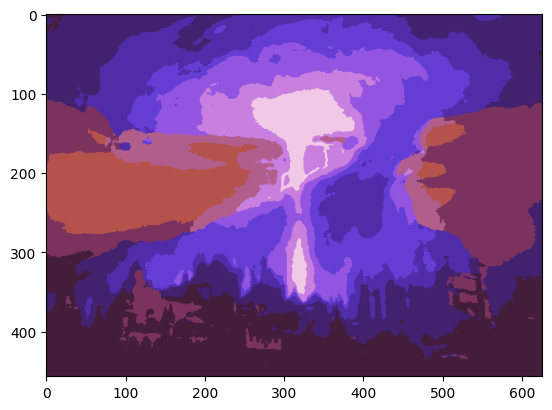

In [27]:
img = cv.imread(search_matches[0]['path'])
Z = img.reshape((-1,3))

# convert to np.float32
Z = np.float32(Z)

# define criteria, number of clusters(K) and apply kmeans()
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 10
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(cv.cvtColor(res2, cv.COLOR_BGR2RGB))


In [18]:
# image = cv.imread(search_matches[0]['path'])

In [19]:

# plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [20]:
result = search_card_data(card_data, name='Black Market Connections', return_all = True) #, illustration_id='54436824-977b-4dc7-8de1-8498e73e5ef2')

data\art\Black_Market_Connections_f8b4a475-948b-4253-85ae-a7a0ebd835c6.jpg
data\art\Black_Market_Connections_e3e4103c-2786-44d2-97aa-dea019850a8f.jpg
data\art\Black_Market_Connections_cda3caaf-009d-4f84-8fbf-fbe02e638600.jpg


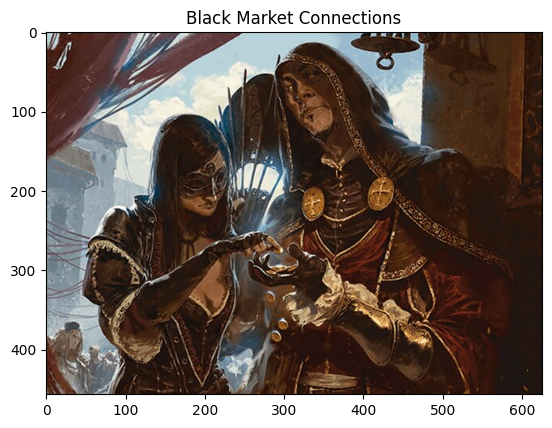

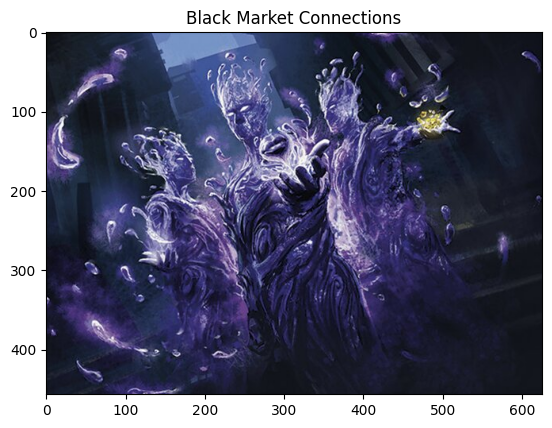

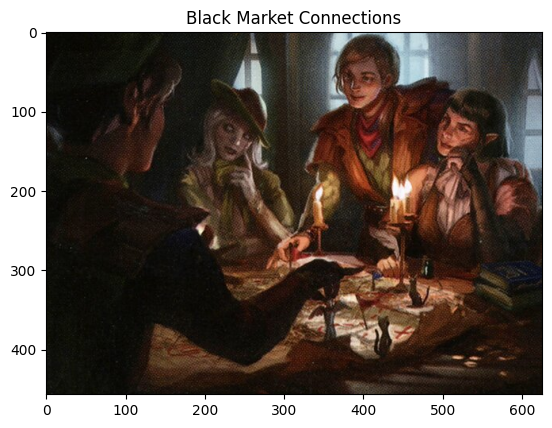

In [ ]:
# # print(result['path'])
# for i in range(len(result)):
#     print(result[i]['path'])
#     plt.figure()
#     plt.title(f"{result[i]['name']}")
#     # plt.imshow(cv.cvtColor(cv.imread(result[i]['path']), cv.COLOR_BGR2RGB))
#     plt.imshow(cv.cvtColor(cv.imread(result[i]['path']), cv.COLOR_RGB2BGR))
# # plt.imshow(cv.cvtColor(cv.imread(result['path']), cv.COLOR_BGR2RGB))

In [ ]:
# 